In [1]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

network = dataclasses.replace(MAINNET_APR_2023,
    # The external "interest rate" % p.a. on leased tokens.
    token_lease_fee=0.20,
    # Try REWARD_DECAY + BASELINE_GROWTH to simulate the SP's share of power declining fast.
    reward_decay=REWARD_DECAY,
)
# Number of epochs to simulate.
epochs = 3 * YEAR + 1
# Frequency of statistics output.
stats_interval = DAY

In [2]:
def show_miner_accounting_charts(df):
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(13.4, 4.8))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
    ax2.set_title("Miner cash flow")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def show_miner_fofr(df):
    plt.figure()
    plt.grid(axis='y', color='#EEE')
    plt.plot(df['day'], df['fofr'], label="FoFR")
    plt.title("Miner return on pledge")
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

def compare_configurations(cfgs, title):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(epochs, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13.4, 4.8))

    for label, df in statss.items():
        ax1.plot(df['day'], df['net_equity'], label=label)
        ax2.plot(df['day'], df['fofr'], label=label)

    ax1.grid(axis='y', color='#EEE')
    ax1.set_title("Miner equity - " + title)
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    ax2.grid(axis='y', color='#EEE')
    ax2.set_title("Miner return on pledge")
    ax2.set_xlabel("Day")
    ax2.set_ylabel("FoFR")
    ax2.legend()

    plt.show()

## Repay the shortfall

This mechanism requires the SP to repay the target initial pledge.
The maximum shortfall is calculated from a conservative estimate of repayment ability.
Some fraction of earned rewards is then burned as a fee, and another (larger) fraction,
for mandatory repayments until the shortfall is paid off.

The first simulation shows an SP taking maximum shortfall given a fixed amount of tokens
available to them (as a lease that incurs fees).

The table and charts show a running balance sheet and accumulated cash flow statement.

In [3]:
repay_miner_factory = RepayRatchetShortfallMinerState.factory(
    # The SP is assumed to lease all tokens (alt: opportunity cost of using owned tokens).
    balance=0,
    max_repayment_term=3 * YEAR,
    max_fee_reward_fraction=0.25,
    reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=1.0),
    miner_factory=repay_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
repay_shortfall_df = pd.DataFrame(data=stats)
repay_shortfall_df

,day,epoch,power,balance,lease,pledge_locked,available,net_equity,fofr,reward_earned,fee_burned,lease_fee_accrued,pledge_required,shortfall,shortfall_pct
0,0,1,252853314650112,1000.0000,1000.0002,1000.0000,0.0000,-0.0002,-0.0000,0.0000,0.0000,0.0002,1598.0184,598.0184,37.42
1,1,2881,252853314650112,1002.0424,1000.5466,1002.0424,0.0000,1.4958,0.0015,2.7238,0.6798,0.5483,1598.0184,595.9759,37.29
2,2,5761,252853314650112,1004.0842,1001.0912,1004.0842,0.0000,2.9930,0.0030,5.4468,1.3572,1.0967,1598.0184,593.9342,37.17
3,3,8641,252853314650112,1006.1253,1001.6340,1006.1253,0.0000,4.4913,0.0045,8.1690,2.0323,1.6454,1598.0184,591.8930,37.04
4,4,11521,252853314650112,1008.1658,1002.1750,1008.1658,0.0000,5.9908,0.0060,10.8902,2.7051,2.1944,1598.0184,589.8525,36.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,252853314650112,2067.3819,0.0000,1598.0184,469.3635,2067.3819,1.3644,2513.3274,102.8993,343.0461,1598.0184,0.0000,0.00
1092,1092,3144961,252853314650112,2069.3104,0.0000,1598.0184,471.2920,2069.3104,1.3656,2515.2558,102.8993,343.0461,1598.0184,0.0000,0.00
1093,1093,3147841,252853314650112,2071.2383,0.0000,1598.0184,473.2199,2071.2383,1.3669,2517.1837,102.8993,343.0461,1598.0184,0.0000,0.00
1094,1094,3150721,252853314650112,2073.1655,0.0000,1598.0184,475.1472,2073.1655,1.3681,2519.1110,102.8993,343.0461,1598.0184,0.0000,0.00


<Figure size 640x480 with 0 Axes>

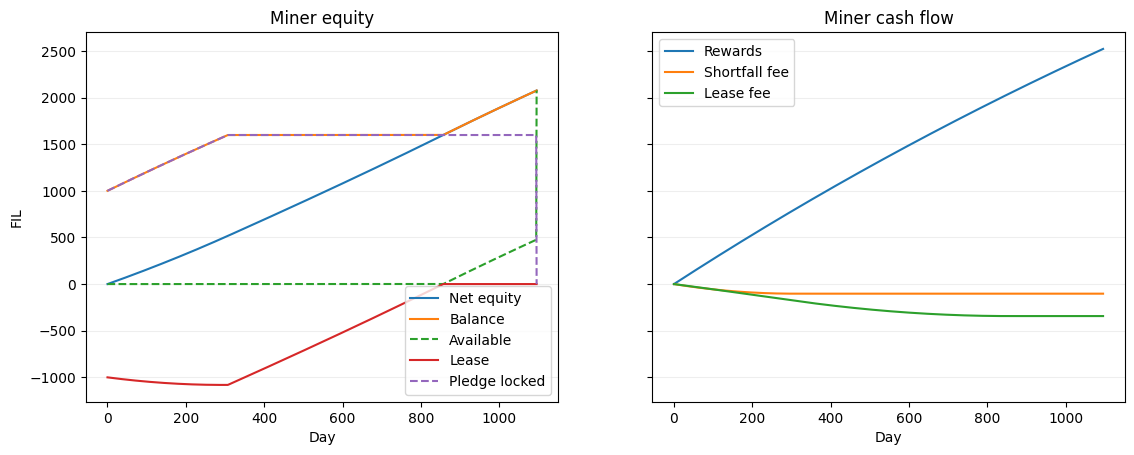

In [4]:
show_miner_accounting_charts(repay_shortfall_df)

<Figure size 640x480 with 0 Axes>

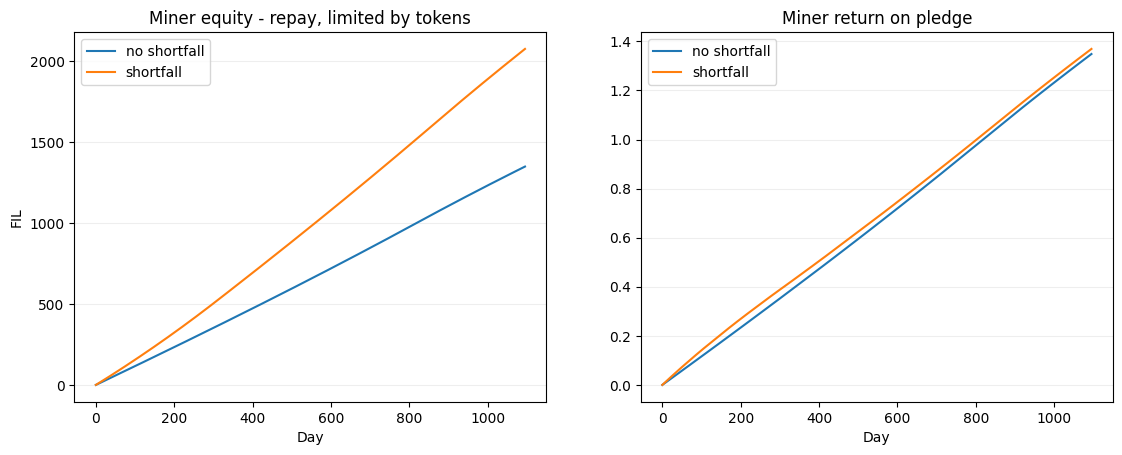

In [5]:
# Configurations limited by token availability.
# The SP is assumed to have abundant hardware and physical capacity, relative to the
# tokens available to them.
# They lock all tokens, and onboard as much power as permitted with/out a shortfall.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=0),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=1.0),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by tokens')

<Figure size 640x480 with 0 Axes>

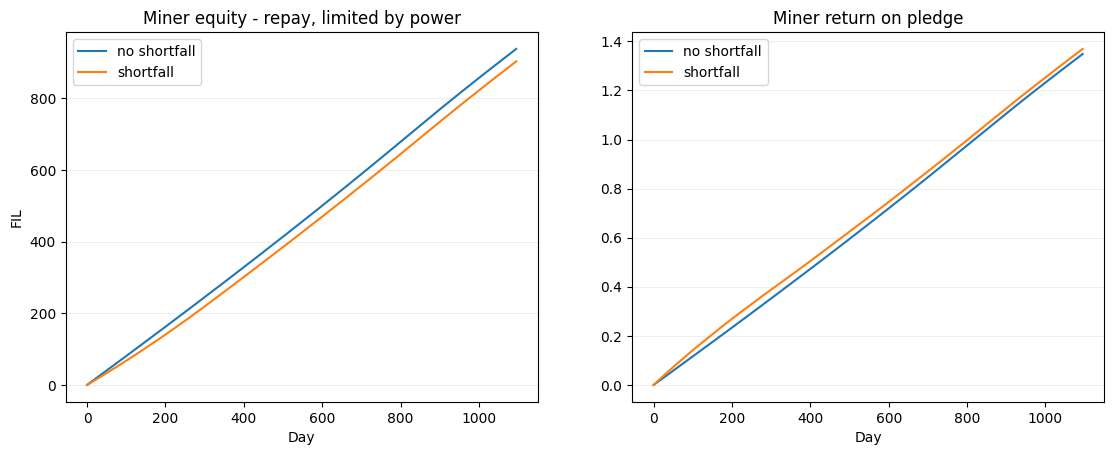

In [6]:
# Configurations limited by power
# The SP is assumed to have ample tokens available for them to lease, but a limited
# amount of power they can onboard (hardware and/or FIL+ data).
# The SP onboards their max power and the required pledge with/out a shortfall.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, shortfall=0),
        miner_factory=repay_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100*TIBIBYTE, 3*YEAR, shortfall=1.0),
        miner_factory=repay_miner_factory,
    )
}, 'repay, limited by power')

## Burn the shortfall

This mechanism requires the SP to burn the difference between the notional initial pledge
and the amount they actually put at stake.
Tokens are burnt as a fraction of earned block rewards, the fraction depending on the
relative size of the outstanding obligation.

In [7]:
burn_miner_factory = BurnShortfallMinerState.factory(balance=0)
cfg = SimConfig(
    network=network,
    strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=1.0),
    miner_factory=burn_miner_factory,
)
stats = Simulator(cfg).run_all(epochs, stats_interval)
burn_shortfall_df = pd.DataFrame(data=stats)
burn_shortfall_df


,day,epoch,power,balance,lease,pledge_locked,available,net_equity,fofr,reward_earned,fee_burned,lease_fee_accrued,fee_pending,shortfall_pct
0,0,1,236154481803264,1000.0000,1000.0002,1000.0,0.0000,-0.0002,-0.0000,0.0000,0.0000,0.0002,492.4827,33.00
1,1,2881,236154481803264,1000.0000,999.1363,1000.0,0.0000,0.8637,0.0009,2.5440,1.1324,0.5479,491.3503,32.95
2,2,5761,236154481803264,1000.0000,998.2711,1000.0,0.0000,1.7289,0.0017,5.0871,2.2631,1.0951,490.2196,32.90
3,3,8641,236154481803264,1000.0000,997.4046,1000.0,0.0000,2.5954,0.0026,7.6295,3.3922,1.6419,489.0905,32.84
4,4,11521,236154481803264,1000.0000,996.5368,1000.0,0.0000,3.4632,0.0035,10.1710,4.5196,2.1882,487.9631,32.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,1091,3142081,236154481803264,1632.3484,0.0000,1000.0,632.3484,1632.3484,1.6323,2347.3432,488.7595,226.2354,3.7232,0.37
1092,1092,3144961,236154481803264,1634.1046,0.0000,1000.0,634.1046,1634.1046,1.6341,2349.1444,488.8044,226.2354,3.6783,0.37
1093,1093,3147841,236154481803264,1635.8604,0.0000,1000.0,635.8604,1635.8604,1.6359,2350.9449,488.8491,226.2354,3.6336,0.36
1094,1094,3150721,236154481803264,1637.6160,0.0000,1000.0,637.6160,1637.6160,1.6376,2352.7449,488.8936,226.2354,3.5891,0.36


<Figure size 640x480 with 0 Axes>

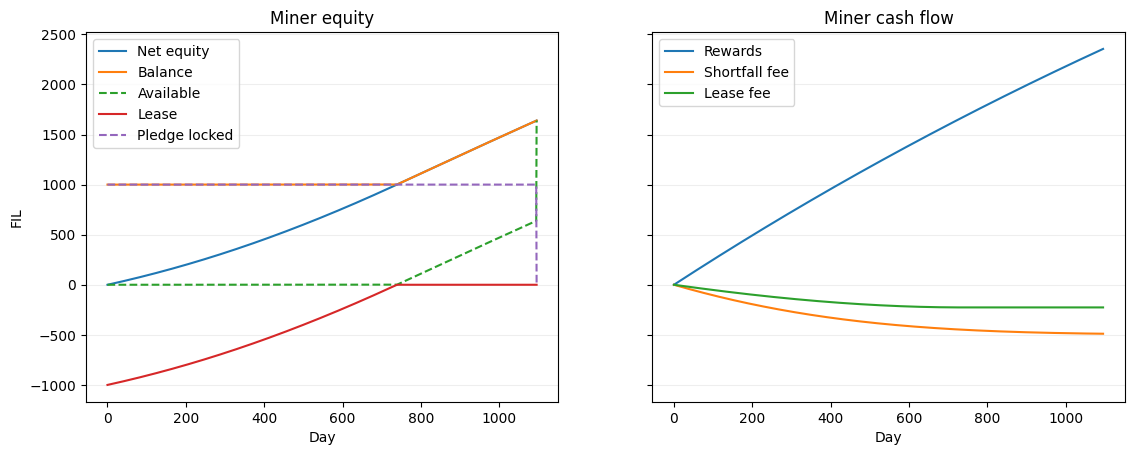

In [8]:
show_miner_accounting_charts(burn_shortfall_df)

<Figure size 640x480 with 0 Axes>

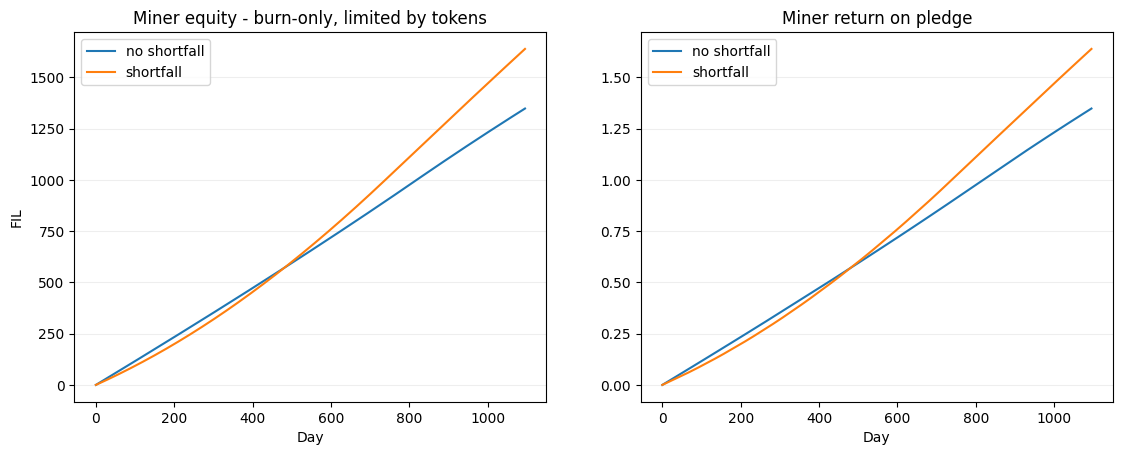

In [9]:
# Configurations limited by token availability.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=0),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, shortfall=1.0),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by tokens')


<Figure size 640x480 with 0 Axes>

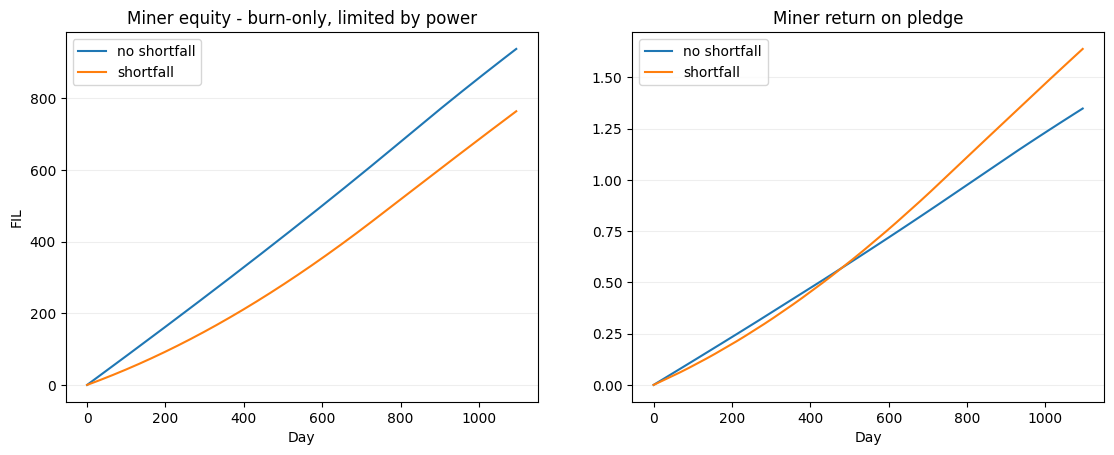

In [10]:
# Configurations limited by power.
compare_configurations({
    'no shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, shortfall=0),
        miner_factory=burn_miner_factory,
    ),
    'shortfall': SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(100 * TIBIBYTE, 3 * YEAR, shortfall=1.0),
        miner_factory=burn_miner_factory,
    )
}, 'burn-only, limited by power')
